In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, LoggingHandler, InputExample, losses, evaluation
from sentence_transformers.losses import SiameseDistanceMetric
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]
LOSS_NAME = "ContrastiveLoss"
POOLING_MODE = "max"

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

pooler = models.Pooling(encoder.get_word_embedding_dimension(), pooling_mode = POOLING_MODE)


model = SentenceTransformer(modules=[encoder, pooler])

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

# Construct Contrastive Dataset

In [3]:
sequences = []
for voc_name in VOC_NAMES:
    sequences.append(pd.read_csv(f"data/unique_{voc_name}_2k.csv")["sequence"].tolist())

# sequences = [["00" + str(i) for i in range(10, 34)],
#              ["10" + str(i) for i in range(10, 34)],
#              ["20" + str(i) for i in range(10, 34)],
#              ["30" + str(i) for i in range(10, 34)],
#              ["40" + str(i) for i in range(10, 34)]]

examples = []
r = 1
done = False
while not done:
    #print("round", r)
    for a_p_list_id in range(len(sequences)):
        n_list_ids = list(range(len(sequences))).copy()
        n_list_ids.remove(a_p_list_id)
        anchor_positive_list = sequences[a_p_list_id]
        anchor_positives = random.sample(anchor_positive_list, 5)
        anchor = anchor_positives[0]
        positives = anchor_positives[1:]
        anchor_positive_list.remove(anchor)
        for positive in positives:
            examples.append(InputExample(texts=[anchor, positive], label=1))
            #print(f"[{anchor}, {positive}, 1]")
            anchor_positive_list.remove(positive)
        

        for n_list_id in n_list_ids:
            negative_list = sequences[n_list_id]
            negative = random.choice(negative_list)
            negative_list.remove(negative)
            examples.append(InputExample(texts=[anchor, negative], label=0))
            #print(f"[{anchor}, {negative}, 0]")
        if len(sequences[0]) < 5 or len(sequences[1]) < 5 or len(sequences[2]) < 5 or len(sequences[3]) < 5 or len(sequences[4]) < 5:
            done = True
            break
    r += 1

# shuffle examples
random.shuffle(examples)

print("len(examples): ", len(examples))
print("len(sequences[0]): ", len(sequences[0]))
print("len(sequences[1]): ", len(sequences[1]))
print("len(sequences[2]): ", len(sequences[2]))
print("len(sequences[3]): ", len(sequences[3]))
print("len(sequences[4]): ", len(sequences[4]))

len(examples):  8864
len(sequences[0]):  4
len(sequences[1]):  4
len(sequences[2]):  4
len(sequences[3]):  8
len(sequences[4]):  8


In [4]:
train_examples = examples[:int(len(examples)*0.8)]
dev_examples = examples[int(len(examples)*0.8):]

print("len(train_examples): ", len(train_examples))
print("len(dev_examples): ", len(dev_examples))

len(train_examples):  7091
len(dev_examples):  1773


In [5]:
batch_size = 200
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(dev_examples, shuffle=False, batch_size=batch_size)

In [6]:
train_loss = losses.ContrastiveLoss(model=model, distance_metric=SiameseDistanceMetric.EUCLIDEAN, margin=5)

In [7]:
evaluator = evaluation.BinaryClassificationEvaluator(sentences1=[dev_example.texts[0] for dev_example in dev_examples],
                                                     sentences2=[dev_example.texts[1] for dev_example in dev_examples],
                                                     labels=[dev_example.label for dev_example in dev_examples],
                                                     batch_size=batch_size,
                                                     show_progress_bar=False,
                                                     write_csv=True,
                                                     name="validation")

In [8]:
import os

# Create output directory if needed
output_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}_eris_omicron_self"
checkpoint_dir = f"{output_dir}/checkpoints"
evaluator_dir = f"{output_dir}/eval"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(evaluator_dir):
    os.makedirs(evaluator_dir)

# read loss values from csv:
train_results_file = os.path.join(output_dir, 'eval', 'training_results.csv')
val_results_file = os.path.join(output_dir, 'eval', 'validation_results.csv')

In [9]:
# Check if the file exists before attempting to delete
if os.path.exists(train_results_file):
    try:
        # Attempt to remove the file
        os.remove(train_results_file)
        print(f"File {train_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {train_results_file} does not exist.")

# Check if the file exists before attempting to delete
if os.path.exists(val_results_file):
    try:
        # Attempt to remove the file
        os.remove(val_results_file)
        print(f"File {val_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {val_results_file} does not exist.")

File ./ContrastiveLoss_output_max_eris_omicron_self/eval/training_results.csv deleted successfully.
File ./ContrastiveLoss_output_max_eris_omicron_self/eval/validation_results.csv deleted successfully.


In [10]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=10,
          optimizer_params= {'lr': 1e-3}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          #evaluation_steps=eval_iter, # run an evalution in every 10% 
          output_path=output_dir,
          save_best_model=True,
          checkpoint_path=checkpoint_dir,
          checkpoint_save_steps=10000000000,
          checkpoint_save_total_limit=2,
          show_progress_bar=True,
          loss_name=LOSS_NAME)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 36.9489   Train Accuracy = 54.9451
Threshold for highest accuracy = 7.4011
Valid Loss = 19.83   Valid Accuracy = 54.43


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 5.5159   Train Accuracy = 58.2418
Threshold for highest accuracy = 0.8602
Valid Loss = 4.38   Valid Accuracy = 54.77


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 3.0340   Train Accuracy = 64.8352
Threshold for highest accuracy = 0.3085
Valid Loss = 5.61   Valid Accuracy = 55.39


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 3.1434   Train Accuracy = 54.9451
Threshold for highest accuracy = 0.3209
Valid Loss = 5.60   Valid Accuracy = 56.01


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 3.2903   Train Accuracy = 51.6484
Threshold for highest accuracy = 0.3897
Valid Loss = 5.45   Valid Accuracy = 56.85


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 2.9072   Train Accuracy = 60.4396
Threshold for highest accuracy = 1.6928
Valid Loss = 3.34   Valid Accuracy = 61.70


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 2.4295   Train Accuracy = 73.6264
Threshold for highest accuracy = 1.7234
Valid Loss = 2.75   Valid Accuracy = 69.49


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 1.9338   Train Accuracy = 84.6154
Threshold for highest accuracy = 2.3321
Valid Loss = 1.87   Valid Accuracy = 79.13


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 1.4516   Train Accuracy = 90.1099
Threshold for highest accuracy = 2.0225
Valid Loss = 1.59   Valid Accuracy = 83.31


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 0.9370   Train Accuracy = 97.8022
Threshold for highest accuracy = 2.4197
Valid Loss = 1.31   Valid Accuracy = 86.13


# TESTING

In [11]:
# create test set with omicron and eris pairs
eris_sequences = pd.read_csv("data/unique_Eris_2081.csv")["sequence"].tolist()[:2000]
omicron_sequences = pd.read_csv("data/unique_Omicron_2k.csv")["sequence"].tolist()
test_examples = []
for i, eris in enumerate(eris_sequences):
        test_examples.append(InputExample(texts=[omicron_sequences[i], omicron_sequences[i]], label=1))
        test_examples.append(InputExample(texts=[omicron_sequences[i], eris], label=0))
print("len(test_examples): ", len(test_examples))
# shuffle test examples
#random.shuffle(test_examples)

len(test_examples):  4000


In [12]:
test_evaluator = evaluation.BinaryClassificationEvaluator(sentences1=[test_example.texts[0] for test_example in test_examples],
                                                     sentences2=[test_example.texts[1] for test_example in test_examples],
                                                     labels=[test_example.label for test_example in test_examples],
                                                     batch_size=100,
                                                     show_progress_bar=False,
                                                     name="test")


best_model_dir = "ContrastiveLoss_output_max_best_model"

best_model = SentenceTransformer(output_dir)
best_model.to("cuda")

# print test duration

import time
start_time = time.time()
test_acc, preds_and_trues = best_model.evaluate(test_evaluator)
duration = time.time() - start_time
print(f"Test duration: {duration:.4f} seconds")

# write test accuracy to file
with open(os.path.join(output_dir, "eval", "test_results_eris_omicron.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")

print(len(preds_and_trues), "test examples")

# print number of incorrect predictions
print(len([pred_true for pred_true in preds_and_trues if pred_true[0] != pred_true[1]]), "incorrect predictions")

print(f"{(duration * 1000 / len(test_examples)):.4f} ms per example")

# write preds and trues to file
with open(os.path.join(output_dir, "eval", "preds_and_trues_eris_omicron.txt"), "w") as f:
    for pred, true in preds_and_trues:
        f.write(f"{pred}, {true}\n")


Threshold for highest accuracy = 0.2016
Valid Loss = 2.89   Valid Accuracy = 100.00
Test duration: 0.9316 seconds
4000 test examples
0 incorrect predictions
0.2329 ms per example


In [13]:
# write a 

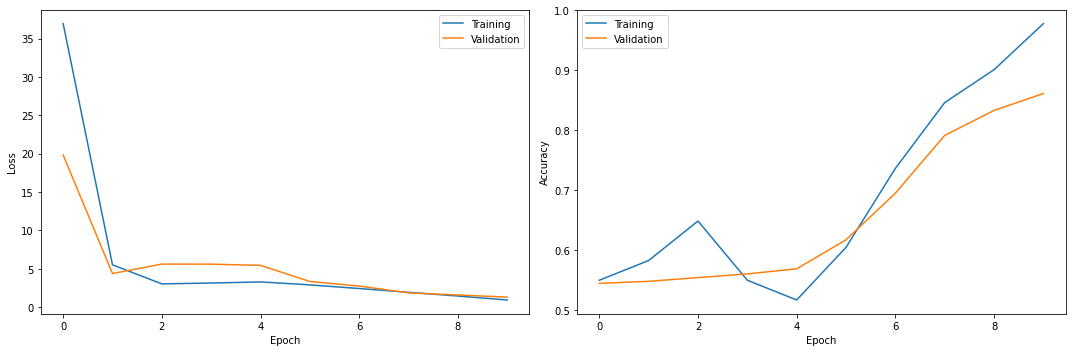

In [14]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# read loss values from csv:
train_results = pd.read_csv(train_results_file)
val_results = pd.read_csv(val_results_file)

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_results["epoch"], train_results["loss"], label="Training")
axs[0].plot(val_results["epoch"], val_results["loss"], label="Validation")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_results["epoch"], train_results["accuracy"], label="Training")
axs[1].plot(val_results["epoch"], val_results["accuracy"], label="Validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(output_dir, "eval", f'plot_{LOSS_NAME}_{POOLING_MODE}_zeroshot.pdf'))
plt.show()